# Background

# Imports

In [1]:
import os

# Basic imports
import pandas as pd
import arrow
import numpy as np
import sklearn.utils

# PyTorch Imports
import torch
import torch.nn as nn

# Torchtext imports for data manipulation
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

# May use transformers over Torchtext depending on how things go
import transformers
# Get BERT from HF as well as Trainer class
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset, load_dataset


import pandas as pd
from torch.utils.data import Dataset, DataLoader


from sklearn import metrics
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

# GPU Setup

In [2]:
# Trigger the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are usisng {device} on a {torch.cuda.get_device_name()}.')


You are usisng cuda on a NVIDIA GeForce GTX 1070.


# Model Setup

We need to set the number of labels for the classificaiton layer to 5 because that is what our data will be looking for, labels ranging from 0 to 4 (0, 1, 2, 3, 4).

In [3]:
# Load the BERT-base-cased model
model_name = 'google-bert/bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)


c:\Users\btb51\miniconda3\envs\ai574_NLP\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Load in BERT with 5 output features
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
# Note we have five outputs for the final classifier layer.
print(f"Classifier Layer: {model.classifier}")

Classifier Layer: Linear(in_features=768, out_features=3, bias=True)


In [7]:
# What kind of tokenizer do we have.
tokenizer

BertTokenizerFast(name_or_path='google-bert/bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

# Load the Dataset

The SST dataset is strucutred in a very unique parse tree structure.  Luckily, HuggingFace has a copy of SST that has the dictionary split with the sentences already split by word and labels created.  The dictionary also provides a lits of tokens, which is the sentence where white space is replaced by pipes (|) and the parse trees in Penn Treebank format.

According to a README.txt file regarding the raw counts of the SST, the labels here range from [0, 1] and then are mapped to five classes from the following thresholds: [0, 0.2], (0.2, 0.4], (0.4, 0.6], (0.6, 0.8], (0.8, 1.0].

In [8]:
ds = pd.read_csv("../data/processed/Dataset_5971.csv")
ds

,LABEL,TEXT,URL,EMAIL,PHONE
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,No,No,No
1,ham,What's up? Do you want me to come online? If y...,No,No,No
2,ham,So u workin overtime nigpun?,No,No,No
3,ham,"Also sir, i sent you an email about how to log...",No,No,No
4,Smishing,Please Stay At Home. To encourage the notion o...,No,No,No
...,...,...,...,...,...
5966,ham,:( but your not here....,No,No,No
5967,ham,Becoz its &lt;#&gt; jan whn al the post ofic...,No,No,No
5968,ham,Its a valentine game. . . send dis msg to all ...,No,No,No
5969,ham,We r outside already.,No,No,No


I believe I need to rename `label` to `labels`... I'll do this later because I need to do some clever work in getting labels to be integers for the classification.

In [9]:
cols = {'LABEL':'labels'}
ds.rename(columns=cols, inplace=True)
ds

,labels,TEXT,URL,EMAIL,PHONE
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,No,No,No
1,ham,What's up? Do you want me to come online? If y...,No,No,No
2,ham,So u workin overtime nigpun?,No,No,No
3,ham,"Also sir, i sent you an email about how to log...",No,No,No
4,Smishing,Please Stay At Home. To encourage the notion o...,No,No,No
...,...,...,...,...,...
5966,ham,:( but your not here....,No,No,No
5967,ham,Becoz its &lt;#&gt; jan whn al the post ofic...,No,No,No
5968,ham,Its a valentine game. . . send dis msg to all ...,No,No,No
5969,ham,We r outside already.,No,No,No


The labels Spam and spam are the same as well as Smishing and smishing.  I'll push them all to lowercase.

In [11]:
ds['labels'] = ds['labels'].str.lower()
ds.labels.unique()

array(['ham', 'smishing', 'spam'], dtype=object)

Text(0.5, 1.0, 'Training Data Labels')

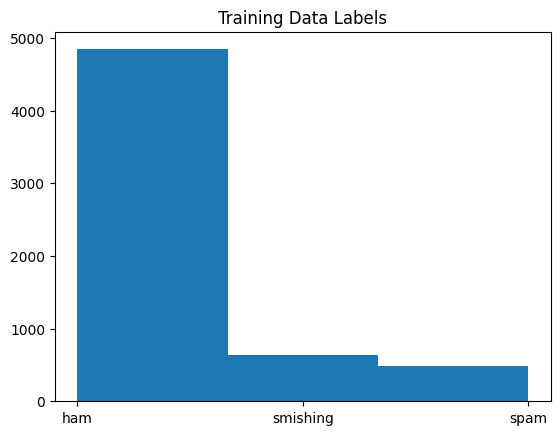

In [12]:
# A distribution of the sentence labels
# This corresponds to the eventual binning of the 5 categories
plt.hist(ds['labels'], bins=3)
plt.title('Training Data Labels')

It can be seen by the histogram above the the data is heavily weighted to the ham values.  We may need to balance this dataset.

I'm also curious just to see what the largest length of our data is.  BERT will only take a 512.

In [13]:
max_len = 0
for item in ds['TEXT']:
    if len(item) > max_len:
        max_len = len(item)

print(f'The max text length is: {max_len}')

The max text length is: 910


This is longer than BERT's max input of 512.  I wonder what the average length is for the dataset.

In [14]:
storage = 0
for item in ds['TEXT']:
    storage += len(item)

print(f'The average text length is: {storage/len(ds):.2f}')

The average text length is: 83.24


That's a lot better for BERT.  What's the distribution of lengths?

(array([3.762e+03, 2.053e+03, 9.800e+01, 3.600e+01, 1.500e+01, 2.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  2. ,  92.8, 183.6, 274.4, 365.2, 456. , 546.8, 637.6, 728.4,
        819.2, 910. ]),
 <BarContainer object of 10 artists>)

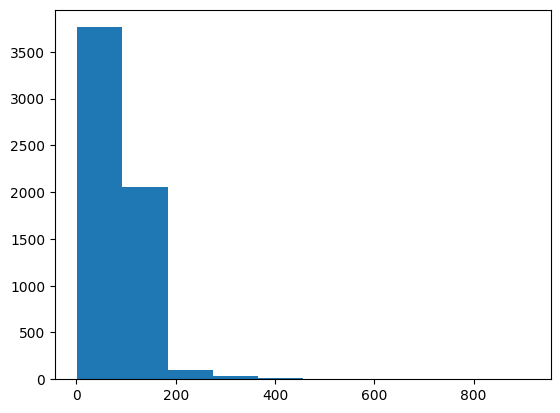

In [15]:
length_list = []
for item in ds['TEXT']:
    length_list.append(len(item))

plt.hist(length_list)

The lengths are primarily smaller lengths.  There will be a lot of Padding then.

In [16]:
ds[['labels', 'URL', 'EMAIL', 'PHONE']] = ds[['labels', 'URL', 'EMAIL', 'PHONE']].astype('category')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5971 entries, 0 to 5970
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   labels  5971 non-null   category
 1   TEXT    5971 non-null   object  
 2   URL     5971 non-null   category
 3   EMAIL   5971 non-null   category
 4   PHONE   5971 non-null   category
dtypes: category(4), object(1)
memory usage: 70.6+ KB


In [17]:
ds['labels'] = ds['labels'].cat.codes
ds['URL'] = ds['URL'].cat.codes
ds['EMAIL'] = ds['EMAIL'].cat.codes
ds['PHONE'] = ds['PHONE'].cat.codes
ds

,labels,TEXT,URL,EMAIL,PHONE
0,0,Your opinion about me? 1. Over 2. Jada 3. Kusr...,0,0,0
1,0,What's up? Do you want me to come online? If y...,0,0,0
2,0,So u workin overtime nigpun?,0,0,0
3,0,"Also sir, i sent you an email about how to log...",0,0,0
4,1,Please Stay At Home. To encourage the notion o...,0,0,0
...,...,...,...,...,...
5966,0,:( but your not here....,0,0,0
5967,0,Becoz its &lt;#&gt; jan whn al the post ofic...,0,0,0
5968,0,Its a valentine game. . . send dis msg to all ...,0,0,0
5969,0,We r outside already.,0,0,0


In [19]:
train_ds, temp_ds = train_test_split(ds[['labels','TEXT', 'URL', 'EMAIL', 'PHONE']], test_size=0.2, random_state=226)
val_ds, test_ds = train_test_split(temp_ds, test_size=0.3, random_state=226)


train_ds = train_ds.reset_index(drop=True)
val_ds = val_ds.reset_index(drop=True)
test_ds = test_ds.reset_index(drop=True)

print(f'Lengths of training: {len(train_ds)}')
print(f'Lengths of validation: {len(val_ds)}')
print(f'Lengths of test: {len(test_ds)}')

Lengths of training: 4776
Lengths of validation: 836
Lengths of test: 359


In [20]:
train_ds

,labels,TEXT,URL,EMAIL,PHONE
0,0,Sorry i missed your call. Can you please call ...,0,0,0
1,0,"Pete,is this your phone still? Its Jenny from ...",0,0,0
2,0,Let's pool our money together and buy a bunch ...,0,0,0
3,0,"Whenevr ur sad, Whenevr ur gray, Remembr im he...",0,0,0
4,2,Want 2 get laid tonight? Want real Dogging loc...,0,0,1
...,...,...,...,...,...
4771,1,\tRefused a loan? Secured or Unsecured? Can't ...,0,0,1
4772,0,U WILL SWITCH YOUR FONE ON DAMMIT!!,0,0,0
4773,0,The guy did some bitching but I acted like i'd...,0,0,0
4774,0,"idc get over here, you are not weaseling your ...",0,0,0


How do the distributions between the train and test set look?

(array([3872.,    0.,    0.,    0.,    0.,  515.,    0.,    0.,    0.,
         389.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

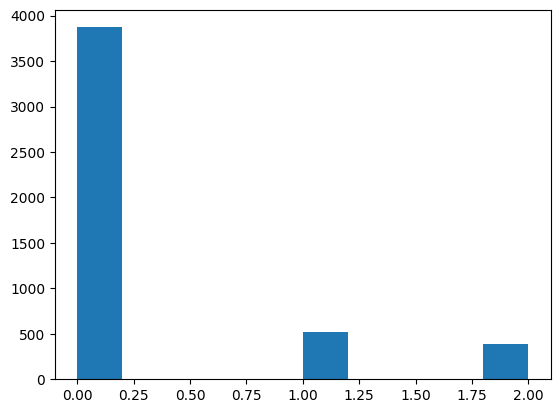

In [21]:
# Training
plt.hist(train_ds['labels'])

(array([691.,   0.,   0.,   0.,   0.,  82.,   0.,   0.,   0.,  63.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

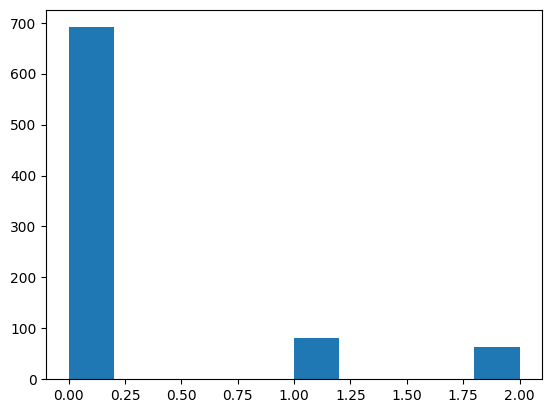

In [22]:
# Val
plt.hist(val_ds['labels'])

(array([281.,   0.,   0.,   0.,   0.,  41.,   0.,   0.,   0.,  37.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

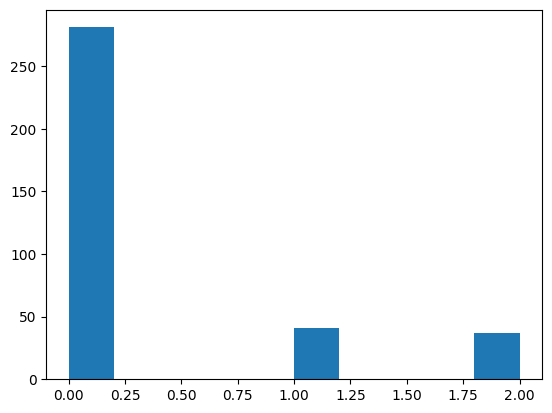

In [23]:
# Test
plt.hist(test_ds['labels'])

The distributions are similar.

In [24]:
from datasets import DatasetDict, Dataset # bring this in again to make sure I have the right one.

# Run the rebinning via the map function
train_dataset = Dataset.from_pandas(train_ds)
val_datset = Dataset.from_pandas(val_ds)
test_dataset = Dataset.from_pandas(test_ds)

train_dataset

Dataset({
    features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE'],
    num_rows: 4776
})

In [25]:
val_datset

Dataset({
    features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE'],
    num_rows: 836
})

In [26]:
test_dataset

Dataset({
    features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE'],
    num_rows: 359
})

In [59]:
data = DatasetDict({
    'train': train_dataset,
    'val': val_datset,
    'test': test_dataset
})
data

DatasetDict({
    train: Dataset({
        features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE'],
        num_rows: 4776
    })
    val: Dataset({
        features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE'],
        num_rows: 836
    })
    test: Dataset({
        features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE'],
        num_rows: 359
    })
})

This matches the above histogram.

We now have all the sentence data mapped to five categorical labels.  We are now in a good place to begin tokenizing and fine-tuning the model.

# Tokenizing

We can now tokenize all of the sentences by fine-tuning the BERT tokenizer.
Let's just run a quick tokenizer test to ensure we know how it works.

In [30]:
# A quick test to ensure the tokenizer is working as expected.
test = tokenizer('Hello there.')
print(f"Input_ids: {test['input_ids']}\nConversion back: {tokenizer.convert_ids_to_tokens(test['input_ids'])}")


Input_ids: [101, 8667, 1175, 119, 102]
Conversion back: ['[CLS]', 'Hello', 'there', '.', '[SEP]']


## To add_tokens or not add_tokens...

Currently, our SST dataset is primarily focused on what I will call 'normal' English words.  The train/test datasets are not made up of highly specific scientific jargon.  However, there are specific names that do crop up in the data.  These names may not be in the tokenizer.  I could sift through all of the training data sentences, and word by word create a list of new words to add to the tokenizer via tokenizer.add_tokens(wordList), but at the moment I will leave the tokenizer as is and see how it performs.

If I did go this route, I'd have to resize the bert embedding layer word_embeddings to go from 29886 to whatever the new len(tokenizer) is.

In [31]:
print(f'Length of the tokenizer: {len(tokenizer)}\nCurrent word_embedding: {model.bert.embeddings.word_embeddings}')

Length of the tokenizer: 28996
Current word_embedding: Embedding(28996, 768, padding_idx=0)


## Tokenizing the Data

Now let's tokenize everything with a function to mapped.

In [32]:
# Create a tokenizing function to apply via a map
def tokenize_the_data(dskey):
    # Set the max length to 512 as that is the BERT max.
    tokenized_data = tokenizer(dskey['TEXT'], padding='max_length', max_length=512, truncation=True,
                               return_tensors='pt', return_attention_mask=True )
    return tokenized_data

In [33]:
# tokenize the data
tokenized_dataset = DatasetDict({
    'train': train_dataset.map(tokenize_the_data),
    'val': val_datset.map(tokenize_the_data),
    'test': test_dataset.map(tokenize_the_data)
})

Map:   0%|          | 0/4776 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

In [38]:
# Check the tokenized_dataset for its layout
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4776
    })
    val: Dataset({
        features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 836
    })
    test: Dataset({
        features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 359
    })
})

Some tokenized dataset values to check to ensure it worked as inteneded.

In [39]:
text_holder = np.array(tokenized_dataset['train']['input_ids'][0]).flatten()
# text_holder = text_holder[0]
print(f"Input_ids: {tokenized_dataset['train']['input_ids'][0]}\nConversion back: {tokenizer.convert_ids_to_tokens(text_holder)}")

Input_ids: [[101, 6502, 178, 4007, 1240, 1840, 119, 2825, 1128, 4268, 1840, 1171, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [40]:
tokenized_dataset['train']['labels'][0]

0

In [41]:
np.array(tokenized_dataset['train']['attention_mask'][0][0]).flatten()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Data Cleanup

The tokenized dataset still has extra columns that are no longer needed.  While they should be automatically removed for the forward pass in the Trainer, I'll remove them manually here and save the Trainer the effort.

I'll also end up running into an issue if I don't `squeeze()` my data as the trainer is looking for shapes of (batch, seq_len).  Right now there is an extra dimension that needs to be taken out which I'll do here as well.

In [42]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4776
    })
    val: Dataset({
        features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 836
    })
    test: Dataset({
        features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 359
    })
})

In [45]:
tokenized_dataset_reduced = tokenized_dataset.remove_columns([ 'TEXT', 'URL', 'EMAIL', 'PHONE', 'token_type_ids'])
tokenized_dataset_reduced

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4776
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 836
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 359
    })
})

In [47]:
# Does everything exist that should exist.
# I did drop token_type_ids which may be able to be passed along later... I'll have to get this working first.
assert 'input_ids' in tokenized_dataset_reduced['train'].column_names
assert 'attention_mask' in tokenized_dataset_reduced['train'].column_names
assert 'labels' in tokenized_dataset_reduced['train'].column_names


I'm still running into an issue below on trainer.train() where my input shape is wrong.  I think this is because my tokenized_dataset_reduced['train']['input_ids'] is a list, rather than a Tensor.  I'll try to convert things here.


In [48]:
tokenized_dataset_reduced.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [49]:
type(tokenized_dataset_reduced['train'][0]['input_ids'])

torch.Tensor

In [50]:
for i in range(0, 11):
    print(tokenized_dataset_reduced['train'][i]['input_ids'].shape)

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])


In [51]:
for i in range(0, 11):
    print(tokenized_dataset_reduced['train'][i]['attention_mask'].shape)

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])


Those sizes have an extra dimension, I'll take care of that momentarily.

In [52]:
for i in range(0, 11):
    print(tokenized_dataset_reduced['train'][i]['labels'].shape)

torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])


Testing out how I'll remove the excess dimension.

In [53]:
torch.squeeze(tokenized_dataset_reduced['train']['input_ids']).shape

torch.Size([4776, 512])

In [54]:
torch.squeeze(tokenized_dataset_reduced['train']['labels'])[0]

tensor(0)

The (batch, seq_len) is what I'm looking for.  I need to squeeze my dims.

In [55]:
# Funciton to squeeze my dimensions
def squeeze_dims(dskey):
    if 'input_ids' in dskey:
        dskey['input_ids'] = torch.squeeze(dskey['input_ids'])
    if 'attention_mask' in dskey:
        dskey['attention_mask'] = torch.squeeze(dskey['attention_mask'])
    if 'labels' in dskey:
        dskey['labels'] = torch.squeeze(dskey['labels'])

    return dskey

In [56]:
tokenized_dataset_reduced = tokenized_dataset_reduced.map(squeeze_dims)

Map:   0%|          | 0/4776 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

In [57]:
for i in range(0, 1):
    print(f"input_id shape      : {tokenized_dataset_reduced['test'][i]['input_ids'].shape}")
    print(f"attention_mask shape: {tokenized_dataset_reduced['test'][i]['attention_mask'].shape}")
    print(f"labels shape        : {tokenized_dataset_reduced['test'][i]['labels'].shape}")

input_id shape      : torch.Size([512])
attention_mask shape: torch.Size([512])
labels shape        : torch.Size([])


In [58]:
# Check the first few labels and their types to double check they are integers for the categorization

print(tokenized_dataset_reduced['train']['labels'][:10])  # First 10 labels
print(type(tokenized_dataset_reduced['train']['labels'][0]))  # Type of the first label


tensor([0, 0, 0, 0, 2, 0, 0, 0, 0, 0])
<class 'torch.Tensor'>


That's better.  Now my data is in the proper shape AND the labels are integers for the proper classification.

# Model Fine-Tuning

Now that we have tokenized data, let us fine-tune the BERT model.

I'll do this with the Trainer class which takes TrainingArguments.

In [ ]:
# Set up the Training Args
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1, # Prior runs show that I may be over fitting the data at 25 epochs...
    weight_decay=0.01,
    logging_dir='./logs',
    # logging_steps=10, # This made my loss vs epoch plot too noisy...
    logging_strategy='epoch',
    save_strategy='epoch',
)

In [ ]:
# Set up the Trainer

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors='pt')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_reduced['train'],
    eval_dataset=tokenized_dataset_reduced['test'],
    tokenizer=tokenizer,
    data_collator=data_collator
)



I can probably go up at some point and turn the test into a validation and test set:

- Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)  # 70% train, 30% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 15% each for val/test

- Convert DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Run the Trainer
trainer.train()


# Test Metrics

I can now run predictions on the test set.  I'll use the `trainer.predict` function to generate predictions from the forward pass of the model.  Then I'll look at the logits and take the `maxarg` to determine what the predicted label should be.

In [ ]:
# Generate predictions
preds = trainer.predict(tokenized_dataset_reduced['test'])

In [ ]:
# Grab the logits
preds_logits = preds.predictions

print(f'Example logit: {preds_logits[0]}')

In [ ]:
# Which label does the logit correspond to, use proper axis
preds_labels = np.argmax(preds_logits, axis=1)

print(f'Class Label: {preds_labels[0]}')

In [ ]:
# Get the actual labels from the test set
true_labels = preds.label_ids
print(f'True Label: {true_labels[0]}')

In [ ]:
# Run some metrics on the classification of the model
class_report = metrics.classification_report(true_labels, preds_labels,
                                             target_names=['C0', 'C1', 'C2'])

print(f"Classification Report:\n", class_report)

In [ ]:
# Confusion matrix to see where things are going sideways
cm = metrics.confusion_matrix(true_labels, preds_labels)
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Let's see a histogram of our predictions, this should hopefully be slightly bimodal.
plt.hist(preds_labels);

In [ ]:
# What it should have mapped to
plt.hist(true_labels);

In [ ]:
# Overlay the histograms

plt.hist(preds_labels, bins=5, color='blue', alpha=0.5, label='Predictions')
plt.hist(true_labels, bins=5, color='orange', alpha=0.5, label='Truth')
plt.legend()
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Prediction and Truth Histograms')
plt.show();

In [ ]:
# Grab the losses from the trainer's log history.
training_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
evaluation_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log and 'epoch' in log]


In [ ]:
# Plot the losses per epoch.
plt.plot(range(0,len(training_losses)), training_losses, label='train')
plt.plot(range(0, len(training_losses)), evaluation_losses, label='eval')
plt.legend()
plt.title('Training and Validation Loss per epoch')

In [ ]:
# ROC Curve


# Fine-Tune and Test Class Weights (Imbalanced Data)

In [60]:
# Putting in the Over/Undersampling here.

from imblearn import under_sampling
from datasets import Dataset # Make sure I have the right Dataset
# Resample here

# Resample via undersampling up here

# I'll cut everything down to the m items which is just below the lowest class and still easily batchable
rus = under_sampling.RandomUnderSampler(random_state=226, replacement=False)

# Create a copy of the dataset and convert it to DataFrame
data_under = data.copy()
train_df = pd.DataFrame(data_under['train'])

# Ensure labels are in integer format
train_df['labels'] = train_df['labels'].astype(int)

# Separate features and labels
X = train_df.drop(columns=['labels'])
y = train_df['labels']

# Apply RandomUnderSampler
X_under, y_under = rus.fit_resample(X, y)

# Combine the resampled features and labels back into a DataFrame
train_resampled = X_under.copy()
train_resampled['labels'] = y_under

# Assign the resampled data back to the dataset
data_usample = data.copy()
data_usample['train'] = Dataset.from_pandas(train_resampled, preserve_index=False)

In [61]:
data_usample

{'train': Dataset({
     features: ['TEXT', 'URL', 'EMAIL', 'PHONE', 'labels'],
     num_rows: 1167
 }),
 'val': Dataset({
     features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE'],
     num_rows: 836
 }),
 'test': Dataset({
     features: ['labels', 'TEXT', 'URL', 'EMAIL', 'PHONE'],
     num_rows: 359
 })}

(array([389.,   0.,   0.,   0.,   0., 389.,   0.,   0.,   0., 389.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

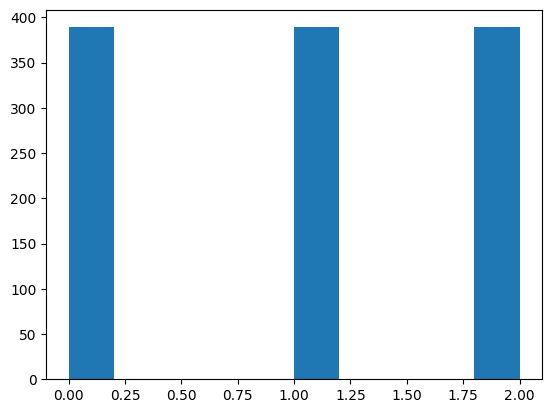

In [ ]:
# Make sure the undersampling is even
plt.hist(data_usample['train']['labels']);

In [ ]:
# Rebuild the data for training with the undersampled set

# Tokenize the undersampled
tokenized_usample_dataset = DatasetDict({
    'train': data_usample['train'].map(tokenize_the_data),
    'validation': data_usample['validation'].map(tokenize_the_data),
    'test': data_usample['test'].map(tokenize_the_data)
})


# Remove extra columns
tokenized_usample_dataset_reduced = tokenized_dataset.remove_columns(['sentence', 'tokens', 'tree', 'token_type_ids', 'label'])
tokenized_usample_dataset_reduced['train'] = tokenized_usample_dataset_reduced['train'].remove_columns([])
tokenized_usample_dataset_reduced


# Does everything exist that should exist.
# I did drop token_type_ids which may be able to be passed along later... I'll have to get this working first.
assert 'input_ids' in tokenized_usample_dataset_reduced['train'].column_names
assert 'attention_mask' in tokenized_usample_dataset_reduced['train'].column_names
assert 'labels' in tokenized_usample_dataset_reduced['train'].column_names


# Set the Tensor format
tokenized_usample_dataset_reduced.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


# Check the dims
for i in range(0, 1):
    print(f"input_id shape      : {tokenized_usample_dataset_reduced['test'][i]['input_ids'].shape}")
    print(f"attention_mask shape: {tokenized_usample_dataset_reduced['test'][i]['attention_mask'].shape}")
    print(f"labels shape        : {tokenized_usample_dataset_reduced['test'][i]['labels'].shape}")


# Check the labels
# Check the first few labels and their types to double check they are integers for the categorization

print(tokenized_usample_dataset_reduced['train']['labels'][:10])  # First 10 labels
print(type(tokenized_usample_dataset_reduced['train']['labels'][0]))  # Type of the first label






In [ ]:
# Set up the Training Args
training_args4 = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5, # Prior runs show that I may be over fitting the data at 25 epochs...
    weight_decay=0.01,
    logging_dir='./logs',
    # logging_steps=10, # This made my loss vs epoch plot too noisy...
    logging_strategy='epoch',
    save_strategy='epoch',
)

In [ ]:
model4 = BertForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

In [ ]:
# Setup trainer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors='pt')

trainer4 = Trainer(
    model=model4,
    args=training_args4,
    train_dataset=tokenized_dataset_reduced['train'],
    eval_dataset=tokenized_dataset_reduced['val'],
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
# Run the trainer
trainer4.train()

In [ ]:
# Grab the losses from the trainer's log history.
training_losses4 = [log['loss'] for log in trainer4.state.log_history if 'loss' in log]
evaluation_losses4 = [log['eval_loss'] for log in trainer4.state.log_history if 'eval_loss' in log and 'epoch' in log]

# Plot the losses per epoch.
plt.plot(range(0,len(training_losses4)), training_losses4, label='train')
plt.plot(range(0, len(training_losses4)), evaluation_losses4, label='eval')
plt.legend()
plt.title('Training and Validation Loss per epoch for U_Sample Data')

In [ ]:
# Get predictions and logits
preds4 = trainer4.predict(tokenized_usample_dataset_reduced['test'])
preds4_logits = preds4.predictions
preds4_labels = np.argmax(preds4_logits, axis=1)
true_labels4 = preds4.label_ids

In [ ]:
# Class Report
# Run some metrics on the classification of the model
class_report4 = metrics.classification_report(true_labels4, preds4_labels,
                                             target_names=['C0', 'C1', 'C2', 'C3', 'C4'])

print(f"Classification Report:\n", class_report)

In [ ]:
# Confusion matrix to see where things are going sideways
cm4 = metrics.confusion_matrix(true_labels4, preds4_labels)
disp = metrics.ConfusionMatrixDisplay(cm4)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Overlay the histograms

plt.hist(preds4_labels, bins=5, color='blue', alpha=0.5, label='Predictions')
plt.hist(true_labels4, bins=5, color='orange', alpha=0.5, label='Truth')
plt.legend()
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Prediction and Truth Histograms for Undersampled Data')
plt.show();

In [ ]:
# ROC Curve




# Might not need anything below this... 

maybe could do a undersample with dropout?

# Fine-Tune and Test Dropout

In [ ]:
# Make a new model to test dropout
model3 = BertForSequenceClassification.from_pretrained(model_name, num_labels=5).to(device)

In [ ]:
for i in range(0, 12):
    model3.bert.encoder.layer[i].attention.self.dropout = nn.Dropout(p=0.5).to(device)
    model3.bert.encoder.layer[i].attention.output.dropout = nn.Dropout(p=0.5).to(device)
    model3.bert.encoder.layer[i].output.dropout = nn.Dropout(p=0.5).to(device)
model3.bert.dropout = nn.Dropout(p=0.5).to(device)

# Partial Dropout test
model3.dropout = nn.Dropout(p=0.5).to(device)

In [ ]:
model3

In [ ]:
# Set up the Training Args
training_args3 = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15, # Prior runs show that I may be over fitting the data at 25 epochs...
    weight_decay=0.01,
    logging_dir='./logs',
    # logging_steps=10, # This made my loss vs epoch plot too noisy...
    logging_strategy='epoch',
    save_strategy='epoch',
)

In [ ]:
# Set up the Trainer

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors='pt')

trainer3 = Trainer(
    model=model3,
    args=training_args3,
    train_dataset=tokenized_dataset_reduced['train'],
    eval_dataset=tokenized_dataset_reduced['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
# Run the Trainer
trainer3.train()


In [ ]:
# Grab the losses from the trainer's log history.
training_losses3 = [log['loss'] for log in trainer3.state.log_history if 'loss' in log]
evaluation_losses3 = [log['eval_loss'] for log in trainer3.state.log_history if 'eval_loss' in log and 'epoch' in log]


# Plot the losses per epoch.
plt.plot(range(0,len(training_losses3)), training_losses3, label='train')
plt.plot(range(0, len(training_losses3)), evaluation_losses3, label='eval')
plt.legend()
plt.title('Training and Validation Loss per epoch for Dropout Test')

In [ ]:
# Grab the losses from the trainer's log history.
training_losses3 = [log['loss'] for log in trainer3.state.log_history if 'loss' in log]
evaluation_losses3 = [log['eval_loss'] for log in trainer3.state.log_history if 'eval_loss' in log and 'epoch' in log]


# Plot the losses per epoch.
plt.plot(range(0,len(training_losses3)), training_losses3, label='train')
plt.plot(range(0, len(training_losses3)), evaluation_losses3, label='eval')
plt.legend()
plt.title('Training and Validation Loss per epoch for Full Dropout Test')